### **Project Introduction**

> Peer-to-peer (P2P) lending platforms have revolutionized the way individuals can invest in and receive loans, removing traditional financial intermediaries from the process.
> While this offers investors greater control, it also places the responsibility on them to assess borrower creditworthiness and construct their own loan portfolios.

This project serves as an analysis for a fictional P2P lending platform.  

The **primary goal** is to:
- Explore the characteristics of loans on the platform
- Model potential risks such as borrower default
- Evaluate the effectiveness of the platform's internal credit rating system

The analysis uses a dataset (`p2ploans.csv`) containing loan characteristics such as:
- Interest rates
- Borrower debt-to-income ratios
- Internal ratings

The insights from this analysis can help the platform:
- Refine its risk models
- Improve its rating system
- Provide better guidance to investors

---



### **Analysis 1: Descriptive Analysis of Yearly Loan Payments**

This analysis examines the properties of yearly loan payments on the platform. These payments are fixed over the loan’s duration and are made directly to the platform rather than to individual investors.

#### **Business Questions**
- What are the typical size and shape of yearly loan payments on the platform?
- Is the distribution of yearly payments symmetric or skewed?
- Which statistical distribution (normal, triangular, or uniform) best models these payments for future forecasting?
- What is the present value(PV) of the platform's largest loan, considering both the first yearly payment and the full loan term?

#### **Implementation**
To address these questions, we:
1. **Calculated descriptive statistics** — mean, median, skewness, and kurtosis — for yearly payments, and compared skewness and kurtosis values to those of a normal distribution.
2. **Visualized the distribution** by constructing a histogram with 20 bins using ggplot2, adding vertical lines for the mean and median, and labeling the axes and title appropriately.
3. **Assessed distribution symmetry** by comparing mean vs. median and analyzing the histogram shape.
4. **Evaluated model** fit by discussing the parameters of the normal, triangular, and uniform distributions, and comparing these to the observed data and histogram.
5. **Identified the loan with the largest yearly payment** and calculated:
   - The present value of its **first yearly payment**, assuming end-of-year payment and discounting at a risk-free rate of **1.72%**.
   - The present value of **all yearly payments over the loan’s duration**, applying the same discount rate.

In [21]:
library(ggplot2)
library(moments)
library(dplyr)

In [2]:
data <- read.csv("data/p2ploans.csv")

In [49]:
# Calculate the mean and median of yearly payments
mean_yearly_payment <- mean(data$yearly_payment)
median_yearly_payment <- median(data$yearly_payment)

cat("Mean Yearly Payment:", round(mean_yearly_payment, 2), "\n")
cat("Median Yearly Payment:", round(median_yearly_payment, 2), "\n")

Mean Yearly Payment: 4918.38 
Median Yearly Payment: 4322.94 


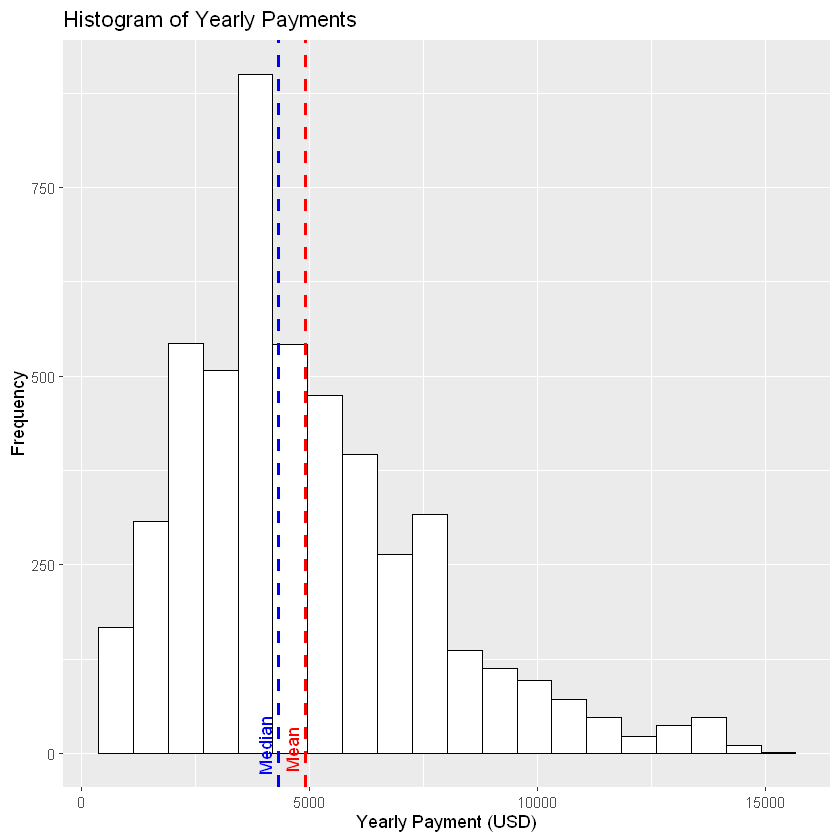

In [8]:
# Plot histogram with mean/median lines
ggplot(data, aes(x = yearly_payment)) +
  geom_histogram(bins = 20, fill = "white", color = "black") +
  geom_vline(aes(xintercept = mean_yearly_payment), color = "red", linetype = "dashed", linewidth = 1) +
  geom_vline(aes(xintercept = median_yearly_payment), color = "blue", linetype = "dashed", linewidth = 1) +
  annotate("text", x = mean_yearly_payment, y = 5, label = paste0("Mean"), color = "red", angle = 90,  vjust = -0.5) +
  annotate("text", x = median_yearly_payment, y = 10, label = paste0("Median"), color = "blue", angle = 90, vjust = -0.5) +
  labs(title = "Histogram of Yearly Payments", x = "Yearly Payment (USD)", y = "Frequency")

In [48]:
# Calculate skewness and kurtosis
skew_moments <- skewness(data$yearly_payment)
kurt_moments <- kurtosis(data$yearly_payment)

cat("Skewness of Yearly Payments:", round(skew_moments, 4), "\n")
cat("Kurtosis of Yearly Payments:", round(kurt_moments, 4), "\n")

Skewness of Yearly Payments: 1.0192 
Kurtosis of Yearly Payments: 4.074 


In [47]:
# Identify loan with largest yearly payment and PV of first payment

# Find the row with the maximum yearly payment
max_yearly_payment_row <- data[which.max(data$yearly_payment), ]

# Extract yearly payment and loan ID
max_yearly_payment <- max_yearly_payment_row$yearly_payment
loan_id <- max_yearly_payment_row$id

# Define risk-free rate
risk_free_rate <- 0.0172

# Present value of the first yearly payment
pv_first_payment <- max_yearly_payment / (1 + risk_free_rate)

cat("Loan with largest yearly payment has ID:", loan_id, "\n")
cat("Largest yearly payment amount:", round(max_yearly_payment, 2), "\n")
cat("Present Value of first yearly payment:", round(pv_first_payment, 2), "\n")


Loan with largest yearly payment has ID: 137 
Largest yearly payment amount: 15020.16 
Present Value of first yearly payment: 14766.18 


In [46]:
# PV of all yearly payments over loan duration

# Extract loan maturity (in years)
loan_duration <- max_yearly_payment_row$maturity

# Initialize total present value
total_present_value <- 0

# Loop through each payment year and discount
for (n in 1:loan_duration) {
  present_value <- max_yearly_payment / (1 + risk_free_rate)^n
  total_present_value <- total_present_value + present_value
}

cat("Total Present Value over loan duration:", round(total_present_value, 2), "\n")


Total Present Value over loan duration: 71375.93 


#### **Results**

- **Mean yearly payment:** `$4,918.38`- noticeably higher than the median of `$4,322.94`, indicating the data is not symmetric.  
- **Skewness:** 1.0192 (positive), **Kurtosis:** 4.074 → distribution is right-skewed and has heavier tails than a normal distribution  (which has kurtosis = 3).  
- Histogram confirms right skew: most payments cluster at the lower end, with a long tail of higher-value payments pulling the mean upward.  
- Best-fitting model: A **triangular distribution** is selected as the best-fitting model because it can effectively capture the observed skewness and the shape visible in the histogram. The triangular distribution parameters include the minimum, maximum, and mode of yearly payments; since yearly payments are fixed over loan durations, the lowest and highest yearly payments can serve as minimum and maximum values.
- A normal distribution is not appropriate as it assumes symmetry (skewness = 0) and a kurtosis of 3, which does not match the positive skewness (1.0192) and heavier tails (kurtosis 4.074) in the data.
- A uniform distribution is also unsuitable because it assumes no skewness and equal likelihood across the range, contradicting the clear skewness and varying frequencies observed.
- Largest yearly payment: **\$15,020.16** (Loan ID: 137)  
  - PV of first payment: \$14,766.18  
  - Total PV of all future payments: \$71,375.93  


### **Analysis 2: Modeling Borrower Default Risk**

This section assesses the financial impact of borrower defaults on the platform's expected revenues.

#### **Business Questions**
- What is the expected value of a single loan payment, considering a 5% default probability?
- How does the expected value change when considering the entire lifetime of a multi-year loan?
- Across the entire platform, what is the expected number, variance, and skewness of loan defaults in a given year?
- What is the aggregate expected payment from a small portfolio of loans under independent and perfectly correlated default scenarios?
- From a risk management perspective, which default scenario is preferable?

#### **Implementation**
To model borrower default risk, we:
1. Calculated the expected value of the first yearly payment for loan ID 5, assuming a **5% probability of default** (payment $0) and **95% probability of full payment**, regardless of the payment year.
2. Computed the expected value of the final (third) yearly payment for the same loan under the same assumptions.
3. Explained the difference between expected values for the first and final payments, noting that defaults earlier in the loan term affect later payments more heavily.
4. Identified the **Binomial distribution** as appropriate to model the number of defaults in the first repayment period, parameterized by the number of loans and default probability.
5. Calculated the expected number of defaults, variance, and skewness of defaults across the full portfolio of 5,000 loans.
6. Calculated the sum of expected payments at the end of the first year for loans with IDs 1 to 10 assuming independent defaults.
7. Modeled the extreme scenario where defaults are perfectly correlated across these 10 loans (all default or none do), and compared mean-variance characteristics with the independent defaults case.
8. Discussed why independent defaults are preferable from a risk management and investor perspective due to diversification benefits, as perfect correlation increases variance dramatically and risk of catastrophic loss.

In [31]:
# Set default probability parameters
prob_default <- 0.05
prob_no_default <- 1 - prob_default

In [32]:
# Expected payment for the first year (loan ID 5)
yearly_payment_loan_id_5 <- data$yearly_payment[data$id == 5]
expected_value_first_year <- prob_no_default * yearly_payment_loan_id_5

In [33]:
# Total expected payment over the full 3-year loan term (loan ID 5)
years <- 3
total_expected_value <- 0
for (year in 1:years) {
  prob_alive <- (1 - prob_default)^(year - 1)   # Probability loan not defaulted before year
  total_expected_value <- total_expected_value + prob_alive * prob_no_default * yearly_payment_loan_id_5
}

In [34]:
# Portfolio-wide default metrics for 5000 loans
num_loans <- nrow(data)
expected_defaults <- num_loans * prob_default
variance_defaults <- num_loans * prob_default * (1 - prob_default)
skewness_defaults <- (1 - 2 * prob_default) / sqrt(num_loans * prob_default * (1 - prob_default))

In [35]:
# Sum of expected payments for loans with IDs 1 to 10 (first year)
loans_1_10 <- data %>% filter(id >= 1 & id <= 10)
total_yearly_payment_1_10 <- sum(loans_1_10$yearly_payment)
total_expected_payment_1_10 <- prob_no_default * total_yearly_payment_1_10

In [36]:
cat("Expected payment for first year (loan ID 5): $", round(expected_value_first_year, 2), "\n")
cat("Total expected payment over 3 years (loan ID 5): $", round(total_expected_value, 2), "\n")
cat("Expected number of defaults in portfolio:", expected_defaults, "\n")
cat("Variance of defaults:", round(variance_defaults, 2), "\n")
cat("Skewness of defaults distribution:", round(skewness_defaults, 4), "\n")
cat("Sum of expected payments for loans 1-10 (first year): $", round(total_expected_payment_1_10, 2), "\n")

Expected payment for first year (loan ID 5): $ 1967.18 
Total expected payment over 3 years (loan ID 5): $ 5611.39 
Expected number of defaults in portfolio: 250 
Variance of defaults: 237.5 
Skewness of defaults distribution: 0.0584 
Sum of expected payments for loans 1-10 (first year): $ 41669.51 


#### **Results**
- For the first year, the expected payment from loan ID 5 is **\$1967.18** (95% of its \$2070.72 payment).
- Over the entire 3-year term, the total expected value is **\$5611.39**, reflecting payments received in years 1 and 2 even if default occurs later, but adjusted down due to default risk compounding.
- Across the portfolio of 5,000 loans, the expected number of defaults in the first year is **250**, with a variance of **237.5** and a low skewness of **0.0584**, indicating a nearly symmetric distribution.
- For a small portfolio of 10 loans, the sum of expected payments is **\$41,669.51** assuming independent defaults; perfect default correlation leads to the same mean but a significantly higher variance, highlighting the risk management advantage of independent defaults.


### **Analysis 3: Evaluating the Internal Rating System**

This analysis evaluates how well the platform’s internal credit ratings explain the variation in interest rates, and whether adding other borrower characteristics improves this explanation.

#### **Business Questions**
- What is the difference in mean interest rates between the safest (AA) and riskiest (HR) loan categories?
- What factors, both within and outside the dataset, might explain this rate difference?
- How much variation in interest rates is explained by the internal ratings alone?
- Does including additional financial variables, such as the debt-to-income ratio (DTI), improve the explanatory power?
- What do the results suggest about the comprehensiveness of the internal rating system?

#### **Implementation**
To evaluate the internal rating system, we:
1. Calculated the mean interest rates for loans rated ‘AA’ and ‘HR’ and computed the difference in percentage points.
2. Discussed possible reasons for the rate differences, including borrower risk factors not captured in the dataset.
3. Used a linear regression (lm) with interest_rate as the dependent variable and internal_rating as a categorical explanatory variable to quantify how much variation ratings explain (R-squared).
4. Extended the model by including dti_ratio as an additional regressor to evaluate changes in model fit (Adjusted R-squared) and statistical significance of DTI.
5. Interpreted whether the internal rating already incorporates most relevant borrower information based on changes in explanatory power and significance of additional variables.

In [37]:
# Compare mean interest rates for AA and HR groups
aa_group <- data %>% filter(internal_rating == "AA")
hr_group <- data %>% filter(internal_rating == "HR")
mean_aa <- mean(aa_group$interest_rate, na.rm = TRUE)
mean_hr <- mean(hr_group$interest_rate, na.rm = TRUE)
difference <- mean_hr - mean_aa

In [42]:
# Output means and difference using cat
cat("Mean interest rate for AA-rated loans:", round(mean_aa , 2), "%\n")
cat("Mean interest rate for HR-rated loans:", round(mean_hr, 2), "%\n")
cat("Difference in mean interest rates (HR - AA):", round(difference, 2), "percentage points\n")

Mean interest rate for AA-rated loans: 5.65 %
Mean interest rate for HR-rated loans: 30.35 %
Difference in mean interest rates (HR - AA): 24.7 percentage points


In [39]:
# Linear regression: interest rate on internal rating
model <- lm(interest_rate ~ internal_rating, data = data)
summary_model <- summary(model)

In [40]:
# Extract R-squared
r_squared <- summary_model$r.squared

cat("R-squared for regression with internal rating only:", round(r_squared * 100, 2), "%\n")

R-squared for regression with internal rating only: 96.75 %


In [44]:
# Add dti_ratio to the model
model_with_dti <- lm(interest_rate ~ internal_rating + dti_ratio, data = data)
summary_model_dti <- summary(model_with_dti)

# Extract adjusted R-squared
adj_r_squared <- summary_model_dti$adj.r.squared

# Extract coefficient and p-value for dti_ratio
coef_dti <- summary_model_dti$coefficients["dti_ratio", "Estimate"]
pval_dti <- summary_model_dti$coefficients["dti_ratio", "Pr(>|t|)"]

cat("Adjusted R-squared with internal rating and dti_ratio:", round(adj_r_squared * 100, 4), "%\n")
cat("Coefficient for dti_ratio:", round(coef_dti, 4), "\n")
cat("P-value for dti_ratio coefficient:", signif(pval_dti, 4), "\n")

Adjusted R-squared with internal rating and dti_ratio: 96.766 %
Coefficient for dti_ratio: 0.0097 
P-value for dti_ratio coefficient: 6.678e-09 


#### **Results**
- There is a large **24.7 percentage point difference** in mean interest rates between AA-rated loans (5.65%) and HR-rated loans (30.35%), consistent with risk-return expectations.
- The internal rating explains a substantial **96.75% of the variance** in interest rates (R-squared = 0.9675).
- Adding `dti_ratio` marginally increases the Adjusted R-squared to **0.9677**. Although statistically significant (p < 0.05), the effect size is very small—a 1% increase in DTI corresponds to only a 0.0097% increase in interest rate.
- **Conclusion:** The internal rating system is highly effective, capturing most relevant risk information including factors related to debt-to-income ratio, leaving little explanatory power for additional variables.

### **Analysis 4: Simulating Portfolio-Level Losses with Rating-Specific Default Probabilities**

This final analysis performs a Monte Carlo simulation to model the distribution of total payments from the two riskiest loan groups (E and HR), using rating-specific default probabilities, and quantifies potential extreme losses.

#### **Business Questions**
- What is the expected total payment from the riskiest loan portfolio (groups E and HR) in a single year, accounting for rating-specific default probabilities?
- What shape does the distribution of total payments take across simulations, and why?
- What is the 95% Value at Risk (VaR) — the worst expected loss under normal conditions at 95% confidence?

#### **Implementation**
To model losses more accurately, I:
1. Used historical default probabilities provided by internal rating groups:  
   - E: 15% default probability  
   - HR: 30% default probability  
2. Conducted a **Monte Carlo simulation** with 1,000 iterations.  
3. In each iteration, simulated default events independently for every loan in groups E and HR, based on their respective default probabilities.  
4. Calculated total payments by summing yearly payments from non-defaulted loans in that iteration.  
5. After simulations, plotted a histogram of total payments to visualize the distribution.  
6. Computed the mean, standard deviation, and the 5th percentile (95% VaR) of total payments across all simulations.


Mean of total payments: $ 2818954 
Standard deviation of total payments: $ 49852.39 
95% Value at Risk (VaR): $ 2739134 


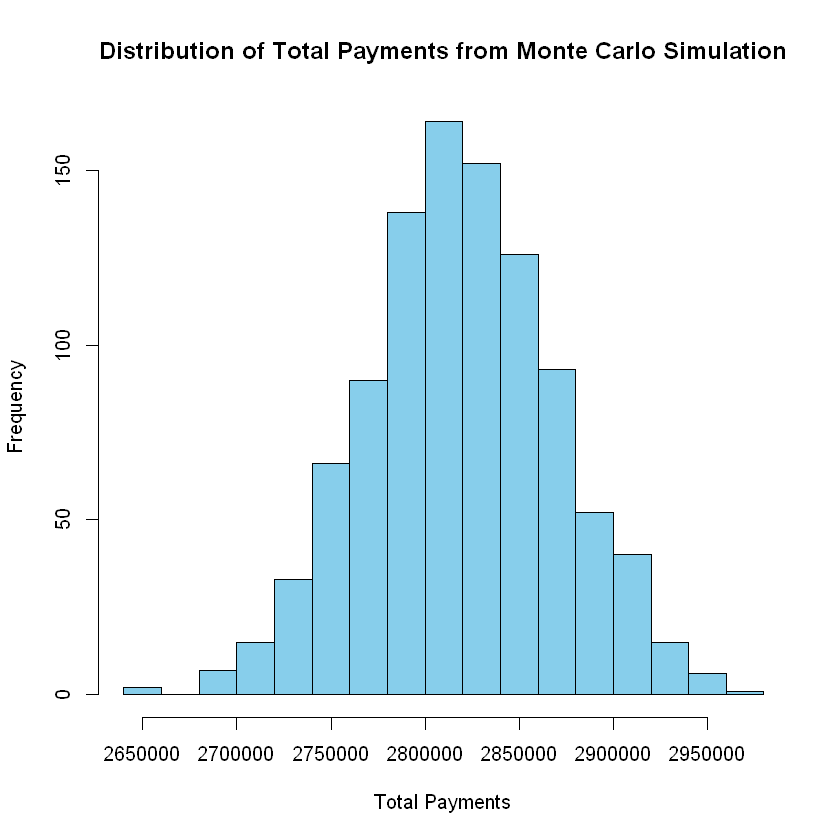

In [45]:
# 4(a) Monte Carlo Simulation for portfolio losses (loan groups E and HR)
loans_E_HR <- data[data$internal_rating %in% c("E", "HR"), ]

# Default probabilities: 15% for 'E', 30% for 'HR'
default_prob <- ifelse(loans_E_HR$internal_rating == "E", 0.15, 0.30)

# Number of simulations
n_simulations <- 1000

# Vector to store total payment results for each simulation
total_payments <- numeric(n_simulations)

set.seed(123)  # for reproducibility

for (i in 1:n_simulations) {
  # Simulate defaults: TRUE if random number < default probability
  defaults <- runif(nrow(loans_E_HR)) < default_prob
  
  # Sum payments for loans that did NOT default in this simulation
  total_payments[i] <- sum(loans_E_HR$yearly_payment[!defaults])
}

# Plot histogram of total payments
hist(total_payments, breaks = 20, col = "skyblue",
     main = "Distribution of Total Payments from Monte Carlo Simulation",
     xlab = "Total Payments",
     ylab = "Frequency")

# 4(c) & 4(d) Calculate summary statistics: Mean, Std Dev, 95% VaR
mean_payments <- mean(total_payments)
std_dev_payments <- sd(total_payments)
VaR_95 <- quantile(total_payments, 0.05)

# Print the results using cat
cat("Mean of total payments: $", round(mean_payments, 2), "\n")
cat("Standard deviation of total payments: $", round(std_dev_payments, 2), "\n")
cat("95% Value at Risk (VaR): $", round(VaR_95, 2), "\n")

#### **Results**
- The distribution of simulated total payments closely resembles a **Normal Distribution**, consistent with the **Central Limit Theorem** as many independent loan payments are summed.
- The mean simulated total payment is **\$2,818,755.69**, with a standard deviation of **\$51,322.30**.
- The **95% Value at Risk (VaR) is \$2,733,656.50**, meaning there is a 95% confidence that total payments will not fall below this amount, highlighting potential tail risk.